In [1]:
import pandas as pd
import matplotlib
import pydot
import re

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import numpy as np
import sklearn
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)


Using TensorFlow backend.


In [2]:
#path of datasets
path_train = 'data/train_dataset.csv'
path_test =  'data/test_dataset.csv'

def display_confusion_matrix(sample_test, prediction, score=None):
    cm = metrics.confusion_matrix(sample_test, prediction)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if score:
        all_sample_title = 'Accuracy Score: {0}'.format(score)
        plt.title(all_sample_title, size = 15)
    print(metrics.classification_report(sample_test, prediction))
    
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz"""
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Function with standardize a dataframe by setting mean to 0 and var to 1
def standardize(df, target=None, categorical=None):
    
    standardize_df = df
    
    if target:
        target_serie = standardize_df[target] # Separating out the target before standardizing
        standardize_df = standardize_df.drop([target],  axis=1)
    
    if categorical:
        cat_serie = standardize_df[categorical] # Separating out categorical feature(s) before standardizing
        standardize_df = standardize_df.drop([categorical],  axis=1)

    # Standardizing the features
    scaled_values = StandardScaler().fit_transform(standardize_df.values)
    standardize_df = pd.DataFrame(scaled_values, index=standardize_df.index, columns=standardize_df.columns)
    
    if target:
        standardize_df = standardize_df.join(target_serie)
        
    if categorical:
        standardize_df = standardize_df.join(cat_serie)
    
    return standardize_df

In [3]:
train_df_raw = pd.read_csv(path_train)
train_df_raw.head()

,用户编码,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,用户账单当月总费用（元）,用户当月账户余额（元）,缴费用户当前是否欠费缴费,用户话费敏感度,当月通话交往圈人数,是否经常逛商场的人,近三个月月均商场出现次数,当月是否逛过福州仓山万达,当月是否到过福州山姆会员店,当月是否看电影,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
0,a4651f98c82948b186bdcdc8108381b4,1,44,0,0,0,186,1,99.80,163.86,159.20,180,0,3,83,1,75,0,0,0,1,1,713,0,2740,7145,0,0,30,664
1,aeb10247db4e4d67b2550bbc42ff9827,1,18,0,0,1,5,1,29.94,153.28,145.10,110,0,3,21,1,16,0,0,0,0,0,414,0,2731,44862,0,0,0,530
2,5af23a1e0e77410abb25e9a7eee510aa,1,47,0,0,0,145,1,49.90,109.64,120.20,70,0,1,59,0,1,0,0,0,0,0,3391,0,0,4804,0,0,1,643
3,43c64379d3c24a15b8478851b22049e4,1,55,0,0,0,234,1,99.80,92.97,167.42,90,0,3,78,1,26,0,0,0,1,1,500,0,1931,3141,0,0,5,649
4,f1687f3b8a6f4910bd0b13eb634056e2,1,40,0,0,0,76,1,49.90,95.47,101.00,80,0,3,70,1,44,0,0,0,1,0,522,0,64,59,0,0,0,648


用户编码去掉
用户实名制是否通过核实去掉


In [4]:
train_df_raw.describe()

,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,用户账单当月总费用（元）,用户当月账户余额（元）,缴费用户当前是否欠费缴费,用户话费敏感度,当月通话交往圈人数,是否经常逛商场的人,近三个月月均商场出现次数,当月是否逛过福州仓山万达,当月是否到过福州山姆会员店,当月是否看电影,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.00000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.99022,37.883440,0.003720,0.048800,0.088580,96.448680,0.700100,53.415929,98.732081,99.575130,114.172400,0.052540,3.351920,48.054500,0.329500,26.572520,0.038700,0.027120,0.242280,0.47442,0.37412,1148.815260,1.197840,971.50308,3.366519e+03,0.704420,0.553340,19.117120,618.053060
std,0.09841,11.613239,0.060879,0.215452,0.284139,59.176593,0.458218,61.812022,60.757758,65.327335,304.063961,0.223116,1.241202,54.208524,0.470036,32.789251,0.192881,0.162435,0.428467,0.49935,0.48390,3992.957952,44.469584,3006.16776,1.151006e+04,28.721302,7.735913,170.074772,42.443022
min,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,422.000000
25%,1.00000,30.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,54.180000,52.675000,40.000000,0.000000,2.000000,16.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,18.000000,0.000000,6.00000,1.000000e+01,0.000000,0.000000,0.000000,594.000000
50%,1.00000,36.000000,0.000000,0.000000,0.000000,94.000000,1.000000,49.900000,89.320000,89.620000,70.000000,0.000000,4.000000,32.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.00000,0.00000,250.000000,0.000000,267.00000,3.350000e+02,0.000000,0.000000,0.000000,627.000000
75%,1.00000,45.000000,0.000000,0.000000,0.000000,139.000000,1.000000,99.800000,131.160000,133.945000,130.000000,0.000000,4.000000,61.000000,1.000000,50.000000,0.000000,0.000000,0.000000,1.00000,1.00000,932.000000,0.000000,1147.25000,2.423250e+03,0.000000,0.000000,4.000000,649.000000
max,1.00000,111.000000,1.000000,1.000000,1.000000,288.000000,1.000000,998.000000,840.570000,1164.290000,49040.000000,1.000000,5.000000,1906.000000,1.000000,92.000000,1.000000,1.000000,1.000000,1.00000,1.00000,234336.000000,8235.000000,496238.00000,1.382227e+06,5856.000000,474.000000,13965.000000,719.000000


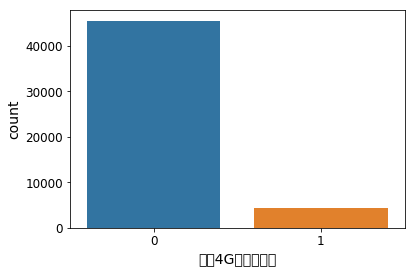

In [5]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
sns.countplot(train_df_raw['是否4G不健康客户'])

In [6]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
用户编码               50000 non-null object
用户实名制是否通过核实        50000 non-null int64
用户年龄               50000 non-null int64
是否大学生客户            50000 non-null int64
是否黑名单客户            50000 non-null int64
是否4G不健康客户          50000 non-null int64
用户网龄（月）            50000 non-null int64
用户最近一次缴费距今时长（月）    50000 non-null int64
缴费用户最近一次缴费金额（元）    50000 non-null float64
用户近6个月平均消费值（元）     50000 non-null float64
用户账单当月总费用（元）       50000 non-null float64
用户当月账户余额（元）        50000 non-null int64
缴费用户当前是否欠费缴费       50000 non-null int64
用户话费敏感度            50000 non-null int64
当月通话交往圈人数          50000 non-null int64
是否经常逛商场的人          50000 non-null int64
近三个月月均商场出现次数       50000 non-null int64
当月是否逛过福州仓山万达       50000 non-null int64
当月是否到过福州山姆会员店      50000 non-null int64
当月是否看电影            50000 non-null int64
当月是否景点游览           50000 non-null int64
当月是否体育场馆消费         50000 non-null int64
当月网购

In [7]:
draw_missing_data_table(train_df_raw)

,Total,Percent
信用分,0,0.0
当月旅游资讯类应用使用次数,0,0.0
用户实名制是否通过核实,0,0.0
用户年龄,0,0.0
是否大学生客户,0,0.0
是否黑名单客户,0,0.0
是否4G不健康客户,0,0.0
用户网龄（月）,0,0.0
用户最近一次缴费距今时长（月）,0,0.0
缴费用户最近一次缴费金额（元）,0,0.0


In [8]:
train_df_raw.shape

(50000, 30)

In [9]:
def preprocess_data(df):
    
    processed_df = df
    
    
    
    processed_df['进行过多少种高端消费（max：7）'] = processed_df['当月是否景点游览'] + processed_df['是否经常逛商场的人'] + \
                                     processed_df['当月是否逛过福州仓山万达'] + processed_df['当月是否到过福州山姆会员店'] + \
                                     processed_df['当月是否看电影'] + processed_df['当月是否景点游览'] + \
                                     processed_df['当月是否体育场馆消费']


    processed_df = processed_df.drop(columns=['当月是否景点游览', '是否经常逛商场的人', '当月是否逛过福州仓山万达',
                                                '当月是否到过福州山姆会员店', '当月是否看电影', '当月是否景点游览',
                                                '当月是否体育场馆消费'])
    # Drop useless columns
    processed_df = processed_df.drop(['用户编码'], 1)

    return processed_df

In [10]:
train_df_raw = preprocess_data(train_df_raw)

In [11]:
train_df_raw.shape

(50000, 24)

In [12]:
# Let's divide the train dataset in two datasets to evaluate perfomance of machine learning models used
train_df = train_df_raw.copy()
X = train_df.drop(['信用分'], 1)
Y = train_df['信用分']


# sc = StandardScaler()
# X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)
    
# Split dataset for prediction
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=21)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=21)

X_train.head()

,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,用户账单当月总费用（元）,用户当月账户余额（元）,缴费用户当前是否欠费缴费,用户话费敏感度,当月通话交往圈人数,近三个月月均商场出现次数,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,进行过多少种高端消费（max：7）
29126,1,40,0,0,0,79,1,199.60,237.53,188.24,60,0,3,154,9,0,0,0,0,0,0,0,4
41262,1,28,0,0,0,86,1,99.80,90.23,90.10,60,0,4,60,0,80,0,6,11,0,0,4,0
24082,1,65,0,0,0,176,1,99.80,52.95,78.00,80,0,3,8,35,412,0,484,144,0,0,1,5
30407,1,48,0,0,0,172,1,49.90,160.09,200.12,150,0,5,66,0,0,0,0,0,0,0,0,0
10191,1,39,0,0,0,25,1,9.98,9.06,11.19,10,0,5,5,0,4,0,0,4,0,0,0,0


In [13]:
num_round = 1444
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # GBDT算法为基础
    'objective': 'regression',  # 回归任务
    'metric': 'rmse',  # 评判指标
    'max_bin': 255,  # 大会有更准的效果,更慢的速度
    'learning_rate': 0.01,  # 学习率
    'num_leaves': 40,  # 大会更准,但可能过拟合
    'max_depth': 8,  # 小数据集下限制最大深度可防止过拟合,小于0表示无限制
    'feature_fraction': 0.61,  # 如果 feature_fraction 小于 1.0, LightGBM 将会在每次迭代中随机选择部分特征.
                              # 例如, 如果设置为 0.8, 将会在每棵树训练之前选择 80% 的特征. 可以处理过拟合
    'bagging_freq': 5,  # 防止过拟合
    'bagging_fraction': 0.75,  # 防止过拟合
    'min_data_in_leaf': 21,  # 防止过拟合
    'min_sum_hessian_in_leaf': 3.0,  # 防止过拟合
    'n_estimator':1444,
    'reg_alpha': 0.5, 
    'reg_lambda': 0.08,
    'header': False  # 数据集是否带表头
        }

In [14]:
import lightgbm as lgb
model_path = 'model.txt'
train_data = lgb.Dataset(X_train, label=Y_train)
# train_data.save_binary('data/train.bin')

# 验证集加载
valid_data = lgb.Dataset(X_val, label=Y_val, reference=train_data)
# valid_data.save_binary('data/valid.bin')

# Train & save model as model.txt
bst = lgb.train(params=params, train_set=train_data, num_boost_round=num_round, valid_sets=None)
bst.save_model(model_path)

In [15]:
def make_predtion(dataset, model_path):
    '''
    :param dataset: 需要预测的数据
    :param model_path: 模型路径
    :return:
    '''

    bst = lgb.Booster(model_file=model_path)
    pred = bst.predict(dataset)

    return pred

In [16]:
def give_a_mark(pred, label):
    '''
    MAE = 1/n * Sum(abs(pred(i) - y(i)))
    Score = 1 / (1 + MAE)
    '''
    pred = np.array(pred)
    label = np.array(label)
    MAE = sum(abs(pred-label)) / float(len(pred))
    score = 1.0 / (1.0 + MAE)
    return score

In [17]:
test_pred = make_predtion(X_test, model_path)
score = give_a_mark(test_pred, Y_test)

print("This Model gets score {}".format(score))

This Model gets score 0.06372767203877429


In [18]:
'''
cv_results = lgb.cv(
    params, train_data, num_boost_round=1175, nfold=5, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=50, show_stdv=True, seed=0)

print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])
'''

"\ncv_results = lgb.cv(\n    params, train_data, num_boost_round=1175, nfold=5, stratified=False, shuffle=True, metrics='rmse',\n    early_stopping_rounds=50, verbose_eval=50, show_stdv=True, seed=0)\n\nprint('best n_estimators:', len(cv_results['rmse-mean']))\nprint('best cv score:', cv_results['rmse-mean'][-1])\n"

In [19]:
'''
params = {    'boosting_type': 'gbdt', 
    'objective': 'regression', 

    'learning_rate': 0.01, 
    'num_leaves': 40, 
    'max_depth': 8,    'min_data_in_leaf': 20,    'subsample': 0.75, 
    'colsample_bytree': 0.61, 
    }

data_train = lgb.Dataset(X_train, Y_train, silent=True)
cv_results = lgb.cv(
    params, data_train, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=100, show_stdv=True)

print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])
'''

"\nparams = {    'boosting_type': 'gbdt', \n    'objective': 'regression', \n\n    'learning_rate': 0.01, \n    'num_leaves': 40, \n    'max_depth': 8,    'min_data_in_leaf': 20,    'subsample': 0.75, \n    'colsample_bytree': 0.61, \n    }\n\ndata_train = lgb.Dataset(X_train, Y_train, silent=True)\ncv_results = lgb.cv(\n    params, data_train, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='rmse',\n    early_stopping_rounds=50, verbose_eval=100, show_stdv=True)\n\nprint('best n_estimators:', len(cv_results['rmse-mean']))\nprint('best cv score:', cv_results['rmse-mean'][-1])\n"